In [ ]:
!pip install tensorflow==2.12.0

INFO: pip is looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.0/586.0 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 81.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 77.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 102.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 113.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 34.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 MB 10.9 MB/s eta 0:00:00
  A

/root/.keras/datasets/cora_extracted/cora
Citations shape: (5429, 2)
Papers shape: (2708, 1435)
                            1906             553                    2153  \
paper_id                  646289          1109873                 642894   
term_0                         0                0                      0   
term_1                         0                0                      0   
term_2                         0                0                      0   
term_3                         0                0                      0   
...                          ...              ...                    ...   
term_1429                      0                0                      0   
term_1430                      0                0                      0   
term_1431                      0                0                      0   
term_1432                      0                0                      0   
subject    Probabilistic_Methods  Neural_Networks  Probabilistic_Met

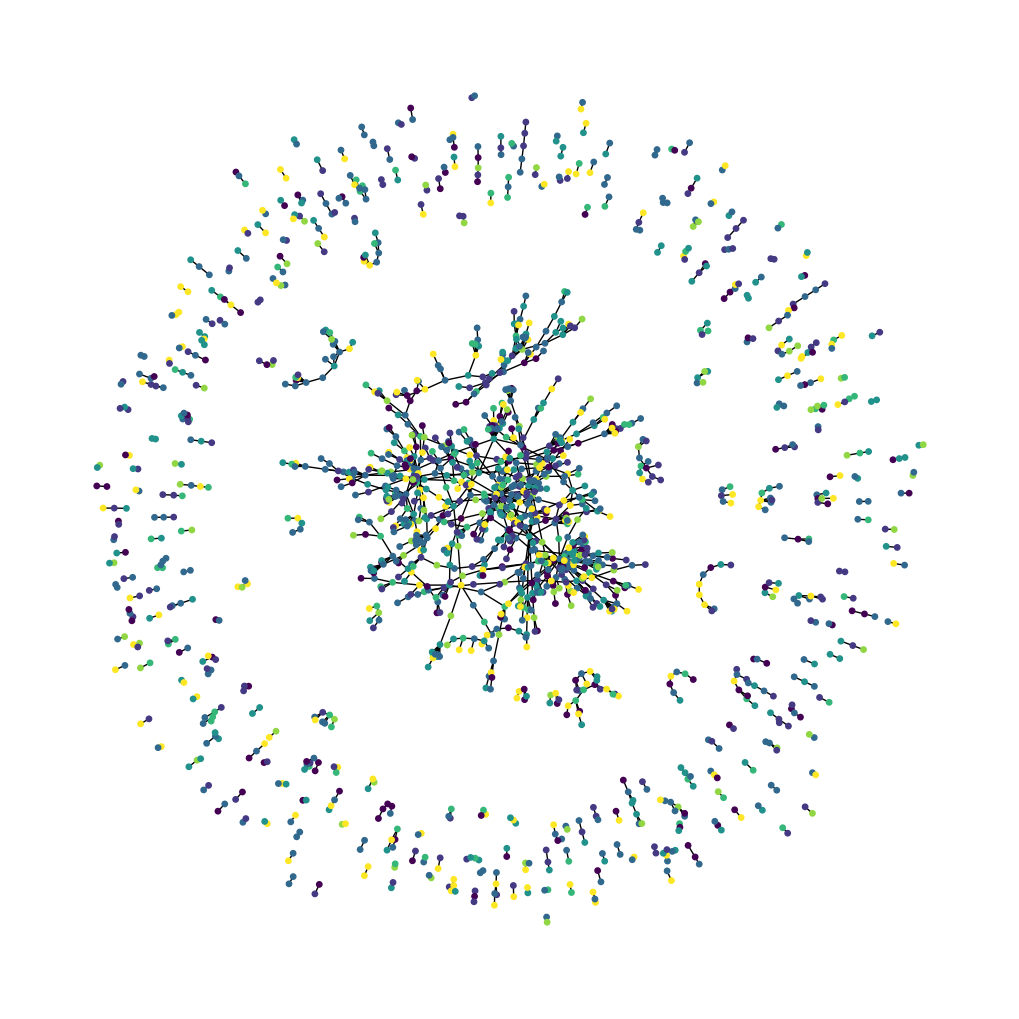

In [ ]:
import os
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

zip_file = keras.utils.get_file(
  fname="cora.tgz",
  origin="https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz",
  extract=True,
)
data_dir = os.path.join(os.path.dirname(zip_file), "cora_extracted/cora")
print(data_dir)
citations = pd.read_csv(
  os.path.join(data_dir, "cora.cites"),
  sep="\t",
  header=None,
  names=["target", "source"],
)
print("Citations shape:", citations.shape)
citations.sample(frac=1).head()
column_names = ["paper_id"] + [f"term_{idx}" for idx in range(1433)] + ["subject"]
papers = pd.read_csv(
  os.path.join(data_dir, "cora.content"), sep="\t", header=None,
  names=column_names,
)
print("Papers shape:", papers.shape)
print(papers.sample(5).T)
print(papers.subject.value_counts())
class_values = sorted(papers["subject"].unique())
class_idx = {name: id for id, name in enumerate(class_values)}
paper_idx = {name: idx for idx, name in enumerate(sorted(papers["paper_id"].unique()))}
papers["paper_id"] = papers["paper_id"].apply(lambda name: paper_idx[name])
citations["source"] = citations["source"].apply(lambda name: paper_idx[name])
citations["target"] = citations["target"].apply(lambda name: paper_idx[name])
papers["subject"] = papers["subject"].apply(lambda value: class_idx[value])
plt.figure(figsize=(10, 10))
colors = papers["subject"].tolist()
cora_graph = nx.from_pandas_edgelist(citations.sample(n=1500))
subjects = list(papers[papers["paper_id"].isin(list(cora_graph.nodes))]
["subject"])
nx.draw_spring(cora_graph, node_size=15, node_color=subjects)
train_data, test_data = [], []
for _, group_data in papers.groupby("subject"):
# Выберем 50% всех примеров для обучения.
  random_selection = np.random.rand(len(group_data.index)) <= 0.5
  train_data.append(group_data[random_selection])
  test_data.append(group_data[~random_selection])
train_data = pd.concat(train_data).sample(frac=1)
test_data = pd.concat(test_data).sample(frac=1)
print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

In [ ]:
hidden_units = [64, 64]
learning_rate = 0.01
dropout_rate = 0.2
num_epochs = 300
batch_size = 256
def run_experiment(model, x_train, y_train):
  # Будем использовать метод Adam во всех моделях для начала
  model.compile(
    optimizer=keras.optimizers.Adam(learning_rate),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
  )
  # Предусмотрим раннюю остановку в моделях.
  early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_acc", patience=50, restore_best_weights=True
  )
  history = model.fit(
    x=x_train,
    y=y_train,
    epochs=num_epochs,
    batch_size=batch_size,
    validation_split=0.2, # выделение на валидацию 15% примеров
    callbacks=[early_stopping],
  )
  return history
def display_learning_curves(history):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
  ax1.plot(history.history["loss"])
  ax1.plot(history.history["val_loss"])
  ax1.legend(["train", "test"], loc="upper right")
  ax1.set_xlabel("Epochs")
  ax1.set_ylabel("Loss")
  ax2.plot(history.history["acc"])
  ax2.plot(history.history["val_acc"])
  ax2.legend(["train", "test"], loc="upper right")
  ax2.set_xlabel("Epochs")
  ax2.set_ylabel("Accuracy")
  plt.show()

Model: "baseline"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_features (InputLayer)    [(None, 1433)]       0           []                               
                                                                                                  
 ffn_block1 (Sequential)        (None, 64)           101924      ['input_features[0][0]']         
                                                                                                  
 ffn_block2 (Sequential)        (None, 64)           8832        ['ffn_block1[0][0]']             
                                                                                                  
 skip_connection2 (Add)         (None, 64)           0           ['ffn_block1[0][0]',             
                                                                  'ffn_block2[0][0]']      

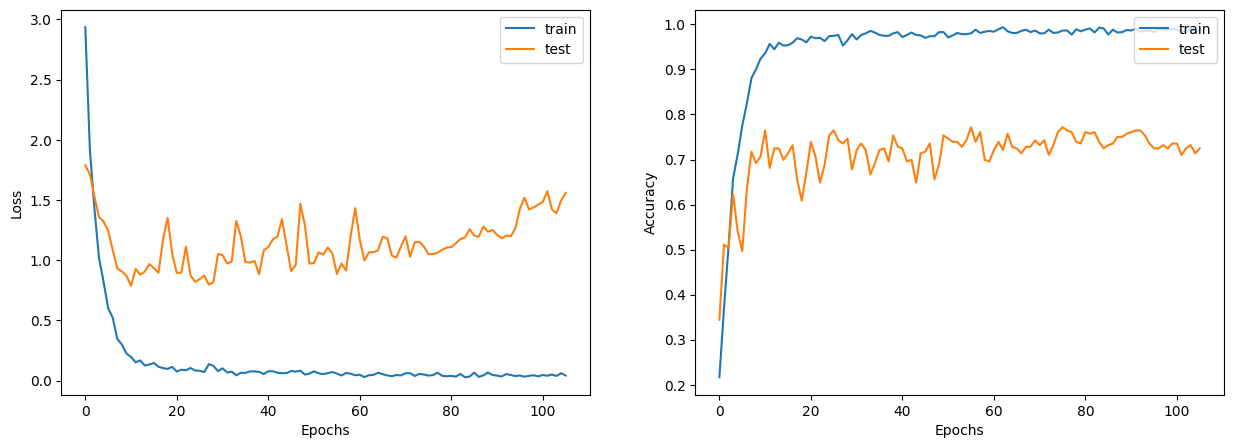

Test accuracy: 70.88%


In [ ]:
def create_ffn(hidden_units, dropout_rate, name=None):
  fnn_layers = []
  for units in hidden_units:
    fnn_layers.append(layers.BatchNormalization())
    fnn_layers.append(layers.Dropout(dropout_rate))
    fnn_layers.append(layers.Dense(units, activation=tf.nn.gelu))
  return keras.Sequential(fnn_layers, name=name)

feature_names = list(set(papers.columns) - {"paper_id", "subject"})
num_features = len(feature_names)
num_classes = len(class_idx)

x_train = train_data[feature_names].to_numpy()
x_test = test_data[feature_names].to_numpy()

y_train = train_data["subject"]
y_test = test_data["subject"]

def create_baseline_model(hidden_units, num_classes, dropout_rate=0.2):
  inputs = layers.Input(shape=(num_features,), name="input_features")
  x = create_ffn(hidden_units, dropout_rate, name=f"ffn_block1")(inputs)
  for block_idx in range(4):
    x1 = create_ffn(hidden_units, dropout_rate, name=f"ffn_block{block_idx + 2}")(x)
    x = layers.Add(name=f"skip_connection{block_idx + 2}")([x, x1])
  logits = layers.Dense(num_classes, name="logits")(x)
  return keras.Model(inputs=inputs, outputs=logits, name="baseline")

baseline_model = create_baseline_model(hidden_units,
num_classes, dropout_rate)
baseline_model.summary()
history = run_experiment(baseline_model, x_train, y_train)
display_learning_curves(history)
_, test_accuracy = baseline_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

In [ ]:
# Список ребер для цитирований (размер [2, num_edges]).
edges = citations[["source", "target"]].to_numpy().T
# Веса в нашей модели отсутсвуют, поэтому зададим их единицами.
edge_weights = tf.ones(shape=edges.shape[1])
# Создадим список для вершин и их признаков [num_nodes, num_features].
node_features = tf.cast(
  papers.sort_values("paper_id")[feature_names].to_numpy(),
  dtype=tf.dtypes.float32
)
# Итоговая структура для описания графа/подграфа в нашей модели
graph_info = (node_features, edges, edge_weights)
print("Edges shape:", edges.shape)
print("Nodes shape:", node_features.shape)

def create_gru(hidden_units, dropout_rate):
  inputs = keras.layers.Input(shape=(2, hidden_units[0]))
  x = inputs
  for units in hidden_units:
    x = layers.GRU(
      units=units,
      activation="tanh",
      recurrent_activation="sigmoid",
      return_sequences=True,
      dropout=dropout_rate,
      return_state=False,
      recurrent_dropout=dropout_rate,
    )(x)
  return keras.Model(inputs=inputs, outputs=x)

class GraphConvLayer(layers.Layer):
  def __init__(
    self,
    hidden_units,
    dropout_rate=0.2,
    aggregation_type="mean",
    combination_type="add",
    normalize=False,
    *args,
    **kwargs,
  ):
    super().__init__(*args, **kwargs)
    self.aggregation_type = aggregation_type
    self.combination_type = combination_type
    self.normalize = normalize
    self.ffn_prepare = create_ffn(hidden_units, dropout_rate)
    if self.combination_type == "gru":
      self.update_fn = create_gru(hidden_units, dropout_rate)
    else:
      self.update_fn = create_ffn(hidden_units, dropout_rate)

  def prepare(self, node_repesentations, weights=None):
    # node_repesentations имеет размер [num_edges, embedding_dim].
    messages = self.ffn_prepare(node_repesentations)
    if weights is not None:
      messages = messages * tf.expand_dims(weights, -1)
    return messages

  def aggregate(self, node_indices, neighbour_messages, node_repesentations):
    # node_indices имеет размер [num_edges].
    # neighbour_messages имеет размер: [num_edges, representation_dim].
    # node_repesentations имеет размер [num_nodes, representation_dim].
    num_nodes = node_repesentations.shape[0]
    if self.aggregation_type == "sum":
      aggregated_message = tf.math.unsorted_segment_sum(
        neighbour_messages, node_indices, num_segments=num_nodes
      )
    elif self.aggregation_type == "mean":
      aggregated_message = tf.math.unsorted_segment_mean(
        neighbour_messages, node_indices, num_segments=num_nodes
      )
    elif self.aggregation_type == "max":
      aggregated_message = tf.math.unsorted_segment_max(
        neighbour_messages, node_indices, num_segments=num_nodes
      )
    else:
      raise ValueError(f"Invalid aggregation type: {self.aggregation_type}.")
    return aggregated_message

  def update(self, node_repesentations, aggregated_messages):
    # node_repesentations имеет размер [num_nodes, representation_dim].
    # aggregated_messages имеет размер [num_nodes, representation_dim].
    if self.combination_type == "gru":
      # Создаем последовательность для слоя GRU
      h = tf.stack([node_repesentations, aggregated_messages], axis=1)
    elif self.combination_type == "concat":
      h = tf.concat([node_repesentations, aggregated_messages], axis=1)
    elif self.combination_type == "add":
      h = node_repesentations + aggregated_messages
    else:
      raise ValueError(f"Invalid combination type: {self.combination_type}.")
    # Применяем на выбор GRU или FFN
    node_embeddings = self.update_fn(h)
    if self.combination_type == "gru":
      node_embeddings = tf.unstack(node_embeddings, axis=1)[-1]
    if self.normalize:
      node_embeddings = tf.nn.l2_normalize(node_embeddings, axis=-1)
    return node_embeddings

  def call(self, inputs):
    node_repesentations, edges, edge_weights = inputs
    # node_indices (source) и neighbour_indices (target) из ребер.
    node_indices, neighbour_indices = edges[0], edges[1]
    # neighbour_repesentations размера [num_edges, representation_dim].
    neighbour_repesentations = tf.gather(node_repesentations, neighbour_indices)
    # Подготовим данные для аггрегации на основе информации об окружении
    neighbour_messages = self.prepare(neighbour_repesentations, edge_weights)
    # Проведем аггрегацию в соответсвии с выбранным алгоритмом.
    aggregated_messages = self.aggregate(
      node_indices, neighbour_messages, node_repesentations
    )
    # Обновим информацию о вложении вершин
    return self.update(node_repesentations, aggregated_messages)

class GNNNodeClassifier(tf.keras.Model):
  def __init__(
    self,
    graph_info,
    num_classes,
    hidden_units,
    aggregation_type="sum",
    combination_type="concat",
    dropout_rate=0.2,
    normalize=True,
    *args,
    **kwargs,
  ):
    super().__init__(*args, **kwargs)
    node_features, edges, edge_weights = graph_info
    self.node_features = node_features
    self.edges = edges
    self.edge_weights = edge_weights
    if self.edge_weights is None:
      self.edge_weights = tf.ones(shape=edges.shape[1])
    self.edge_weights = self.edge_weights / tf.math.reduce_sum(self.edge_weights)
    # Слой для предобработки
    self.preprocess = create_ffn(hidden_units, dropout_rate, name="preprocess")
    # Первый сверточный слой
    self.conv1 = GraphConvLayer(
      hidden_units,
      dropout_rate,
      aggregation_type,
      combination_type,
      normalize,
      name="graph_conv1",
    )
    # Второй сверточный слой
    self.conv2 = GraphConvLayer(
      hidden_units,
      dropout_rate,
      aggregation_type,
      combination_type,
      normalize,
      name="graph_conv2",
    )
    self.conv3 = GraphConvLayer(
      hidden_units,
      dropout_rate,
      aggregation_type,
      combination_type,
      normalize,
      name="graph_conv3",
    )
    self.conv4 = GraphConvLayer(
      hidden_units,
      dropout_rate,
      aggregation_type,
      combination_type,
      normalize,
      name="graph_conv4",
    )
    self.conv5 = GraphConvLayer(
      hidden_units,
      dropout_rate,
      aggregation_type,
      combination_type,
      normalize,
      name="graph_conv5",
    )
    self.conv6 = GraphConvLayer(
      hidden_units,
      dropout_rate,
      aggregation_type,
      combination_type,
      normalize,
      name="graph_conv6",
    )
    # Слой для постобработки
    self.postprocess = create_ffn(hidden_units, dropout_rate, name="postprocess")
    self.compute_logits = layers.Dense(units=num_classes, name="logits")

  def call(self, input_node_indices):
    x = self.preprocess(self.node_features)
    x1 = self.conv1((x, self.edges, self.edge_weights))
    # Простейшая сквозная связь
    x = x1 + x
    x2 = self.conv2((x, self.edges, self.edge_weights))
    # Простейшая сквозная связь
    x = x2 + x
    x3 = self.conv3((x, self.edges, self.edge_weights))
    x = x3 + x
    x4 = self.conv4((x, self.edges, self.edge_weights))
    x = x4 + x
    x5 = self.conv5((x, self.edges, self.edge_weights))
    x = x5 + x
    x6 = self.conv6((x, self.edges, self.edge_weights))
    x = x6 + x
    x = self.postprocess(x)
    node_embeddings = tf.gather(x, input_node_indices)
    return self.compute_logits(node_embeddings)

gnn_model = GNNNodeClassifier(
  graph_info=graph_info,
  num_classes=num_classes,
  hidden_units=hidden_units,
  dropout_rate=0.2,
  name="gnn_model",
)
print("GNN output shape:", gnn_model(input_node_indices=[1,10,100]))
gnn_model.summary()

Edges shape: (2, 5429)
Nodes shape: (2708, 1433)
GNN output shape: tf.Tensor(
[[-0.06484967 -0.01337571  0.00176003  0.02903057 -0.13043709 -0.14234723
   0.08174872]
 [-0.10869905 -0.08516082 -0.12883554 -0.02880758  0.07703158  0.08663543
  -0.25740382]
 [ 0.18267526  0.19763036  0.15346448 -0.00650935  0.05907884 -0.03711015
  -0.02412476]], shape=(3, 7), dtype=float32)
Model: "gnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 preprocess (Sequential)     (2708, 64)                101924    
                                                                 
 graph_conv1 (GraphConvLayer  multiple                 22016     
 )                                                               
                                                                 
 graph_conv2 (GraphConvLayer  multiple                 22016     
 )                                                               
           

Epoch 1/300
5/5 [==============================] - 17s 700ms/step - loss: 2.0736 - acc: 0.2366 - val_loss: 1.8880 - val_acc: 0.3442
Epoch 2/300
5/5 [==============================] - 3s 748ms/step - loss: 1.7141 - acc: 0.3645 - val_loss: 1.8567 - val_acc: 0.3043
Epoch 3/300
5/5 [==============================] - 3s 450ms/step - loss: 1.4118 - acc: 0.4959 - val_loss: 1.6713 - val_acc: 0.3949
Epoch 4/300
5/5 [==============================] - 2s 426ms/step - loss: 1.1049 - acc: 0.6038 - val_loss: 1.3153 - val_acc: 0.5145
Epoch 5/300
5/5 [==============================] - 2s 443ms/step - loss: 0.7954 - acc: 0.7199 - val_loss: 1.1269 - val_acc: 0.5870
Epoch 6/300
5/5 [==============================] - 2s 433ms/step - loss: 0.5541 - acc: 0.8160 - val_loss: 1.0425 - val_acc: 0.6703
Epoch 7/300
5/5 [==============================] - 2s 472ms/step - loss: 0.3898 - acc: 0.8667 - val_loss: 1.1071 - val_acc: 0.6884
Epoch 8/300
5/5 [==============================] - 3s 552ms/step - loss: 0.3060 - 

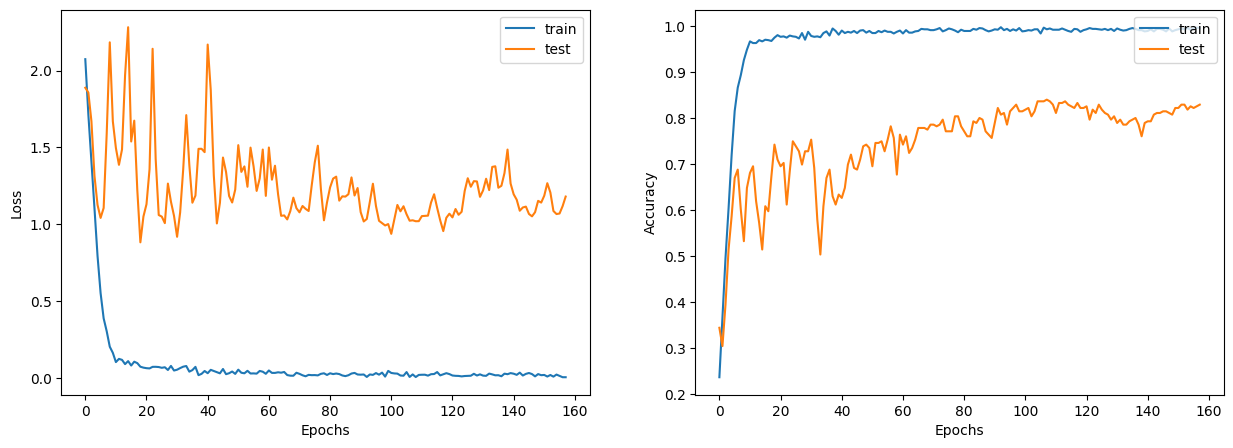

In [ ]:
x_train = train_data.paper_id.to_numpy()
history = run_experiment(gnn_model, x_train, y_train)
display_learning_curves(history)

In [ ]:
class EdgeAttention(layers.Layer):
    def __init__(self, hidden_units, dropout_rate=0.2):
        super().__init__()
        self.attention_ffn = create_ffn(hidden_units, dropout_rate, name="attention_ffn")
        self.attention_scores = layers.Dense(1, activation="sigmoid")

    def call(self, node_features, edges):
        # Получаем признаки для source и target узлов
        source_features = tf.gather(node_features, edges[0])
        target_features = tf.gather(node_features, edges[1])

        # Конкатенируем признаки для вычисления внимания
        edge_features = tf.concat([source_features, target_features], axis=-1)

        # Вычисляем веса внимания
        attention_input = self.attention_ffn(edge_features)
        attention_weights = self.attention_scores(attention_input)

        return tf.squeeze(attention_weights, axis=-1)

class ImprovedGraphConvLayer(layers.Layer):
    def __init__(
        self,
        hidden_units,
        dropout_rate=0.2,
        aggregation_type="mean",
        combination_type="concat",
        normalize=False,
        use_edge_features=False,
        *args,
        **kwargs,
    ):
        super().__init__(*args, **kwargs)
        self.aggregation_type = aggregation_type
        self.combination_type = combination_type
        self.normalize = normalize
        self.use_edge_features = use_edge_features

        # Улучшенная FFN для подготовки сообщений
        self.ffn_prepare = create_ffn(hidden_units, dropout_rate)

        # Механизм внимания для ребер
        if self.use_edge_features:
            self.edge_attention = EdgeAttention(hidden_units, dropout_rate)

        # Улучшенный механизм обновления
        if self.combination_type == "gru":
            self.update_fn = create_gru(hidden_units, dropout_rate)
        else:
            self.update_fn = create_ffn(hidden_units, dropout_rate)

        self.batch_norm = layers.BatchNormalization()

        self.residual_ffn = create_ffn(hidden_units, dropout_rate)

    def prepare(self, node_repesentations, weights=None):
        messages = self.ffn_prepare(node_repesentations)
        if weights is not None:
            messages = messages * tf.expand_dims(weights, -1)
        return messages

    def aggregate(self, node_indices, neighbour_messages, node_repesentations):
        num_nodes = node_repesentations.shape[0]

        if self.aggregation_type == "sum":
            aggregated_message = tf.math.unsorted_segment_sum(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "mean":
            aggregated_message = tf.math.unsorted_segment_mean(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "max":
            aggregated_message = tf.math.unsorted_segment_max(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "attention":
            # Внимание на основе схожести узлов
            neighbour_features = tf.gather(node_repesentations, node_indices)
            attention_scores = tf.reduce_sum(
                neighbour_messages * neighbour_features, axis=-1, keepdims=True
            )
            attention_weights = tf.nn.softmax(attention_scores, axis=0)
            weighted_messages = neighbour_messages * attention_weights
            aggregated_message = tf.math.unsorted_segment_sum(
                weighted_messages, node_indices, num_segments=num_nodes
            )
        else:
            raise ValueError(f"Invalid aggregation type: {self.aggregation_type}.")

        return aggregated_message

    def update(self, node_repesentations, aggregated_messages):
        if self.combination_type == "gru":
            h = tf.stack([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "concat":
            h = tf.concat([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "add":
            h = node_repesentations + aggregated_messages
        else:
            raise ValueError(f"Invalid combination type: {self.combination_type}.")

        node_embeddings = self.update_fn(h)

        if self.combination_type == "gru":
            node_embeddings = tf.unstack(node_embeddings, axis=1)[-1]

        residual = self.residual_ffn(node_repesentations)
        node_embeddings += residual

        node_embeddings = self.batch_norm(node_embeddings)

        if self.normalize:
            node_embeddings = tf.nn.l2_normalize(node_embeddings, axis=-1)

        return node_embeddings

    def call(self, inputs):
        node_repesentations, edges, edge_weights = inputs

        # Вычисляем веса внимания если нужно
        if self.use_edge_features:
            attention_weights = self.edge_attention(node_repesentations, edges)
            edge_weights = edge_weights * attention_weights

        node_indices, neighbour_indices = edges[0], edges[1]
        neighbour_repesentations = tf.gather(node_repesentations, neighbour_indices)

        neighbour_messages = self.prepare(neighbour_repesentations, edge_weights)
        aggregated_messages = self.aggregate(
            node_indices, neighbour_messages, node_repesentations
        )

        return self.update(node_repesentations, aggregated_messages)

class ImprovedGNNNodeClassifier(tf.keras.Model):
    def __init__(
        self,
        graph_info,
        num_classes,
        hidden_units,
        num_layers=3,
        aggregation_type="attention",
        combination_type="concat",
        dropout_rate=0.2,
        normalize=True,
        use_edge_features=True,
        *args,
        **kwargs,
    ):
        super().__init__(*args, **kwargs)
        node_features, edges, edge_weights = graph_info
        self.node_features = node_features
        self.edges = edges
        self.edge_weights = edge_weights

        if self.edge_weights is None:
            self.edge_weights = tf.ones(shape=edges.shape[1])

        self.edge_weights = self.edge_weights / tf.math.reduce_sum(self.edge_weights)

        # Улучшенный preprocessing
        self.preprocess = create_ffn(
            hidden_units * 2, dropout_rate, name="preprocess"
        )

        # Создаем несколько графовых слоев
        self.graph_layers = []
        for i in range(num_layers):
            layer = ImprovedGraphConvLayer(
                hidden_units,
                dropout_rate,
                aggregation_type,
                combination_type,
                normalize,
                use_edge_features,
                name=f"graph_conv_{i}",
            )
            self.graph_layers.append(layer)

        # Улучшенный postprocessing
        self.postprocess = create_ffn(
            hidden_units * 2, dropout_rate, name="postprocess"
        )

        # Добавляем дополнительный dropout для регуляризации
        self.final_dropout = layers.Dropout(dropout_rate / 2)

        # Слой для вычисления logits с инициализацией Xavier
        self.compute_logits = layers.Dense(
            units=num_classes,
            kernel_initializer=tf.keras.initializers.GlorotUniform(),
            name="logits"
        )

        # Skip connection для финальных признаков
        self.skip_ffn = create_ffn(hidden_units, dropout_rate, name="skip_ffn")

    def call(self, input_node_indices, training=False):
        x = self.preprocess(self.node_features)

        # Применяем все графовые слои с residual connections
        for layer in self.graph_layers:
            x_new = layer((x, self.edges, self.edge_weights))
            x = x + x_new  # Residual connection

        x = self.postprocess(x)

        # Добавляем skip connection из начальных признаков
        skip_features = self.skip_ffn(self.node_features)
        x = x + skip_features

        # Применяем финальный dropout только при обучении
        x = self.final_dropout(x, training=training)

        node_embeddings = tf.gather(x, input_node_indices)
        return self.compute_logits(node_embeddings)

# Параметры модели
hidden_units = [256, 256, 128]  # Увеличиваем размерность скрытых слоев
num_layers = 3  # Увеличиваем количество графовых слоев

# Создаем улучшенную модель
improved_gnn_model = ImprovedGNNNodeClassifier(
    graph_info=graph_info,
    num_classes=num_classes,
    hidden_units=hidden_units,
    num_layers=num_layers,
    aggregation_type="attention",  # Используем механизм внимания
    combination_type="concat",
    dropout_rate=0.2,
    use_edge_features=True,
    name="improved_gnn_model",
)

print("Improved GNN output shape:", improved_gnn_model(input_node_indices=[1,10,100]))
improved_gnn_model.summary()

Improved GNN output shape: tf.Tensor(
[[-1.9249562e-03 -1.3200074e-02  3.1540063e-03  7.1437750e-03
  -7.5200252e-02  5.2757394e-02 -4.4708274e-02]
 [ 6.5178081e-02  1.6923541e-02  1.1638483e-02 -1.5895970e-02
  -3.0690493e-02 -1.6790550e-02  2.8039146e-02]
 [-1.0837626e-02 -2.5783405e-02 -2.8059054e-02 -5.9837475e-05
  -3.3070035e-02 -1.0280982e-03  4.8510797e-02]], shape=(3, 7), dtype=float32)


Model: "improved_gnn_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ preprocess (Sequential)         │ (2708, 128)            │       607,844 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ graph_conv_0                    │ ?                      │       604,289 │
│ (ImprovedGraphConvLayer)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ graph_conv_1                    │ ?                      │       604,289 │
│ (ImprovedGraphConvLayer)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ graph_conv_2                    │ ?                      │       604,289 │
│ (ImprovedGraphConvLayer)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ postprocess (Sequential)        │ (2708, 128)            │       268,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_160 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ logits (Dense)                  │ (3, 7)                 │           903 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ skip_ffn (Sequential)           │ (2708, 128)            │       473,572 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,163,730 (12.07 MB)

 Trainable params: 3,134,446 (11.96 MB)

 Non-trainable params: 29,284 (114.39 KB)

Epoch 1/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 134s 13s/step - acc: 0.2605 - loss: 2.5812 - val_acc: 0.6324 - val_loss: 1.6890
Epoch 2/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 46s 92ms/step - acc: 0.6755 - loss: 1.2067 - val_acc: 0.6324 - val_loss: 1.2905
Epoch 3/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - acc: 0.8504 - loss: 0.5595 - val_acc: 0.6801 - val_loss: 1.1158
Epoch 4/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - acc: 0.9133 - loss: 0.3350 - val_acc: 0.6765 - val_loss: 1.2685
Epoch 5/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - acc: 0.9342 - loss: 0.2107 - val_acc: 0.6507 - val_loss: 1.5844
Epoch 6/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - acc: 0.9430 - loss: 0.1987 - val_acc: 0.6324 - val_loss: 1.7008
Epoch 7/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - acc: 0.9531 - loss: 0.1361 - val_acc: 0.6250 - val_loss: 1.7480
Epoch 8/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - acc: 0.9509 - loss: 0.1598 - val_acc: 0.4412 - val_loss: 4.2451
Epoch 9/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - acc: 0.9583 - los

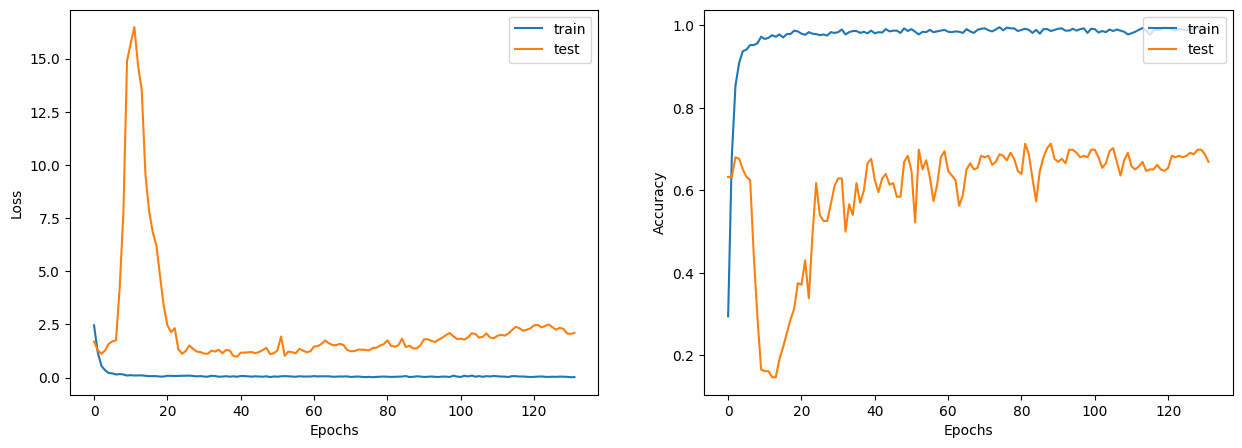

In [ ]:
x_train = train_data.paper_id.to_numpy()
history = run_experiment(improved_gnn_model, x_train, y_train)
display_learning_curves(history)

In [ ]:
_, test_accuracy = baseline_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 69.93%


$$HD(S_{semi-auto}, S_{manual}) = max( max_{a∈S_{semi-auto}} min_{b∈S_{manual}} ||a-b||, max_{b∈S_{manual}} min_{a∈S_{semi-auto}} ||a-b|| )$$